# Lecture : Graph Generation Models

## Lab 03 : WGAN model for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda:2


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 640x480 with 0 Axes>

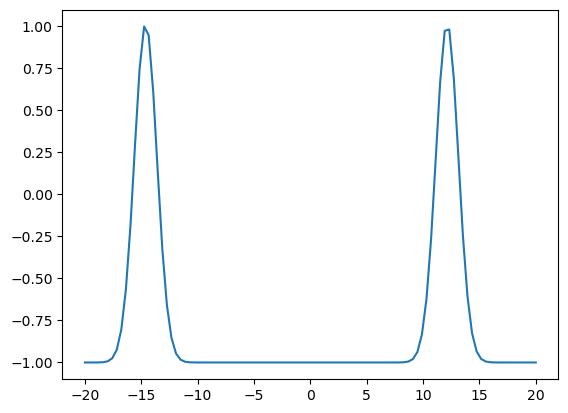

<Figure size 640x480 with 0 Axes>

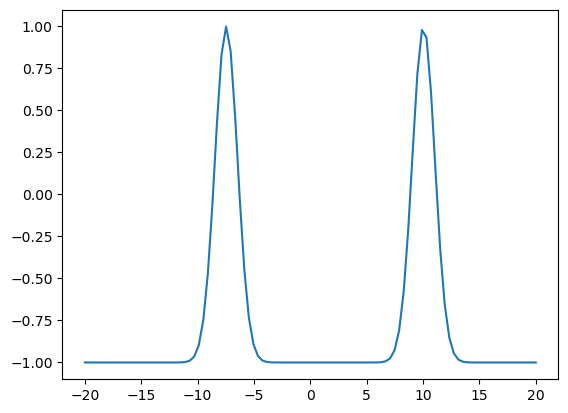

In [4]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# Design the class of WGAN model [1,2,3] with Transformers [4] 

[1] Goodfellow et-al, Generative Adversarial Networks, 2014, https://arxiv.org/pdf/1406.2661  
[2] Arjovsky et-al, Wasserstein GAN, 2017, https://arxiv.org/pdf/1701.07875  
[3] Gulrajani et-al, Improved Training of Wasserstein GANs, 2017, https://arxiv.org/pdf/1704.00028  
[4] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762    



In [5]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 16 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_discriminator = 2 # number of transformer discriminator layers
num_layers_generator = 2 # number of transformer generator layers
drop = 0.0 # dropout value
dropout_dis = 0.05 # dropout value for the discriminator network
bs = 50 # batch size
print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50


In [ ]:
# Define WGAN architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)     # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

# Question 1: Implement the WGAN architecture

#### Step 1: Construct the generator
- Build the generator network using `BlockGT`.
- Map noise `z` into features for each data point.
- Go through the generator network.
- Map the output data embedding into the generated data. \
Notice the usage of `LayerNorm`.

#### Step 2: Define the discriminator
- Build the discriminator network using `BlockGT`.
- Go through the discriminator network.
- According to all output data embeddings, predict the discriminator value of the given input sample. \

Notices:
- The number of layers of generator and discriminator can be the same.
- The dropout layer is used after each layer of the discriminator.

#### Step 3: Design WGAN
Initialize the generator and the discriminator, and code their forward process.


In [ ]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_z = nn.Linear(dz, n*d)
        self.ln_h = nn.LayerNorm(n*d)
        ###############################################
        # Initialize generator network
        # YOUR CODE STARTS
        ###############################################
        self.gt_gen_layers = 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, z, pe):  
        # input layer
        ###############################################
        # noise z -> initial features for data points
        # YOUR CODE STARTS
        ###############################################
        h =  # [bs, n*d] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        h = self.ln_h(h) # [bs, n*d] 
        h = nn.LeakyReLU()(h) # [bs, n*d] 
        bs2 = h.size(0)
        h = h.view(bs2, n, d) # [bs, n, d]
        h = h + pe[:bs2,:,:] # [bs, n, d]
        ###############################################
        # Go through generator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output    
        h =  # [bs, n, d] 
        ###############################################
        # embedding h -> generated data
        # YOUR CODE STARTS
        ###############################################
        h =  # [bs, n] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return h

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()   
        self.h_emb = nn.Linear(1, d)
        ###############################################
        # Initialize discriminator network and dropout layers
        # YOUR CODE STARTS
        ###############################################
        self.gt_dis_layers = 
        self.dp_dis_layers = 
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        self.linear_out = nn.Linear(n*d, 1)   
    def forward(self, h, pe): 
        # input layer
        h = self.h_emb(h.unsqueeze(2)) # [bs, n, d]
        h = h + pe                     # [bs, n, d] 
        ###############################################
        # Go through discriminator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        # output
        h = # [bs, n*d]
        ###############################################
        # Predict the truth of the input `h`
        # YOUR CODE STARTS
        ###############################################
        h = # [bs, 1]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return h

class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.generator = generator()
        self.discriminator = discriminator()
    def forward_gen(self, z):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g_z = 
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return g_z
    def forward_dis(self, h):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        d_h = 
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return d_h

# Question 2: Code the training pipeline of WGAN, including optimizer, loss, and backward pass

Hints:
- Separate the parameters from the generator and the discriminator, and set different optimizers for them.
- Training losses for the generator and the discriminator are as follows:
\begin{eqnarray*}
    &&\quad\quad\ \textrm{Discriminator Loss: } \mathbb{L}_D(\phi)=\mathbb{E}(D_\phi(x_{real}))-\mathbb{E}(D_\phi(x_{gen}))+\lambda(||\bigtriangledown_{\hat{x}}D_\phi(\hat{x})||_2-1)\\
&&\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\ \textrm{where } \hat{x}=\epsilon x_{real}+(1-\epsilon)x_{gen}, \epsilon\sim\mathcal{N}(0, I)\\
&&\quad\quad\ \textrm{Generator Loss: } \mathbb{L}_G(\theta)=-\mathbb{E}(D_\phi(x_{gen}))=-\mathbb{E}(D_\phi(G_\theta(z)))
\end{eqnarray*}

For the discriminator loss, use [torch.autograd.grad(outputs, inputs, grad_outputs, create_graph)](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to get the gradient of `outputs` over `inputs`.   
`grad_outputs` lets you specify the gradient values at the output tensor to propagate backward.   
`create_graph=True` allows us to use the gradients as part of the loss.


In [ ]:
# Instantiate the network
net = WGAN()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
###############################################
# Separate parameters, define different optimizers
# YOUR CODE STARTS
###############################################
optimizer_g = 
optimizer_d = 
###############################################
# YOUR CODE ENDS
###############################################

idx_data = torch.LongTensor(bs).random_(0,N)
x_real = train_data[idx_data,:].to(device) # [bs, n]
print('x_real',x_real.size())
z = torch.rand(bs, dz).to(device) # [bs, dz]
print('z',z.size())

x_fake = net.forward_gen(z) # [bs, n]
print('x_fake',x_fake.size())
fake_discr = net.forward_dis(x_fake) # [bs, 1]    
real_discr = net.forward_dis(x_real) # [bs, 1]
print('fake_discr',fake_discr.size())
print('real_discr',real_discr.size())

###############################################
# Calculate discriminator loss, and back propagate
# YOUR CODE STARTS
###############################################
loss = 
optimizer_d
###############################################
# YOUR CODE ENDS
###############################################

z = torch.rand(bs, dz).to(device) # [bs, dz]
###############################################
# Calculate generator loss, and back propagate
# YOUR CODE STARTS
###############################################
loss = 
optimizer_g
###############################################
# YOUR CODE ENDS
###############################################

Number of parameters: 1128578 (1.13 million)
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50


/home/deeplearn/miniconda3/envs/gnn_course_gpu/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch= 0    time= 0.1345 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02564    loss_g= 0.40739
epoch= 1    time= 0.2693 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03082    loss_g= -0.9867
epoch= 2    time= 0.4038 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.04561    loss_g= -4.1005
epoch= 3    time= 0.5388 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03905    loss_g= -5.9389
epoch= 4    time= 0.6735 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03040    loss_g= -8.2988
epoch= 5    time= 0.8080 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01979    loss_g= -11.057
epoch= 6    time= 0.9428 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02747    loss_g= -14.445
epoch= 7    time= 1.0774 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.04037    loss_g= -15.253
epoch= 8    time= 1.2123 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03460    loss_g= -16.358
epoch= 9    time= 1.3471 min    lr_d= 0.0003000    lr_g

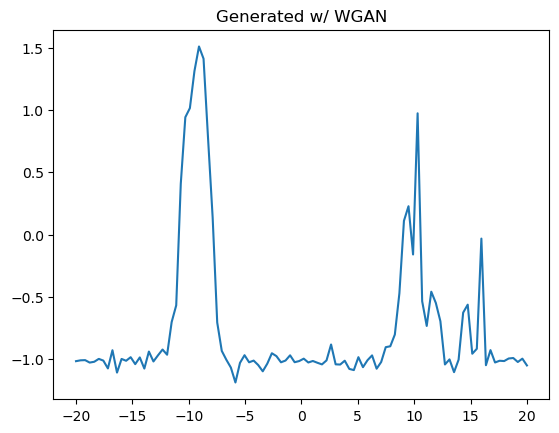

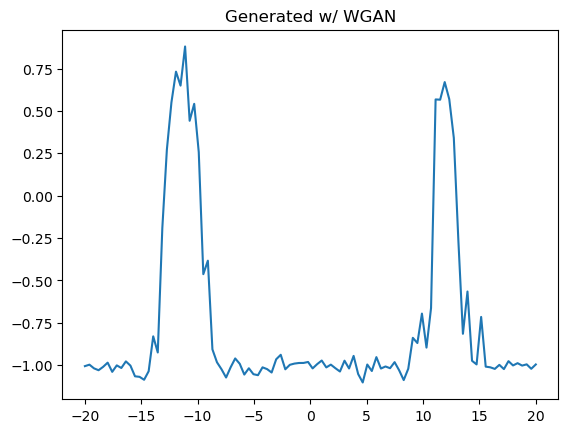

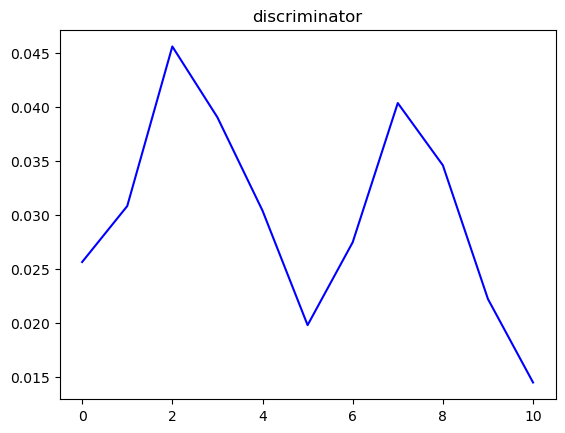

epoch= 11    time= 1.6231 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01510    loss_g= -32.212
epoch= 12    time= 1.7601 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01624    loss_g= -36.191
epoch= 13    time= 1.8962 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01377    loss_g= -39.040
epoch= 14    time= 2.0317 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01458    loss_g= -42.478
epoch= 15    time= 2.1699 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01993    loss_g= -46.158
epoch= 16    time= 2.3094 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01163    loss_g= -50.649
epoch= 17    time= 2.4515 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01513    loss_g= -54.723
epoch= 18    time= 2.5938 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01104    loss_g= -59.050
epoch= 19    time= 2.7297 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01099    loss_g= -62.996
epoch= 20    time= 2.8732 min    lr_d= 0.00030

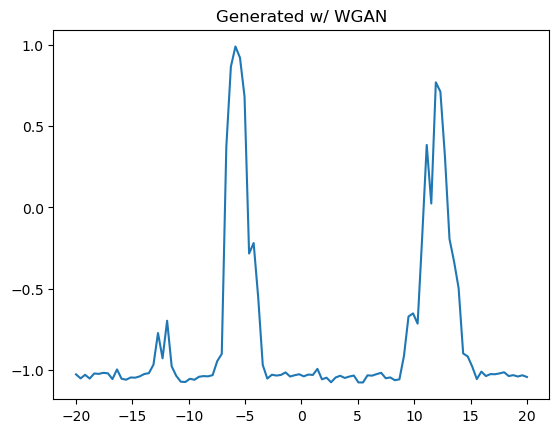

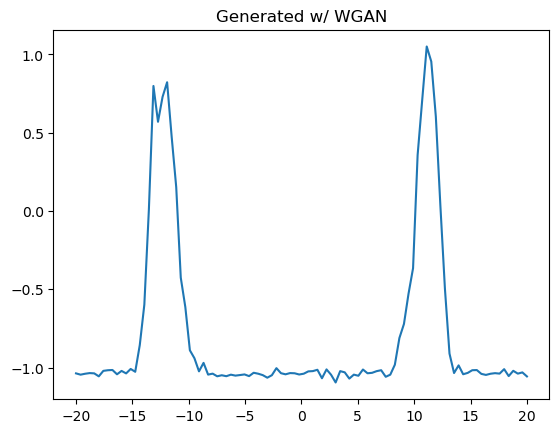

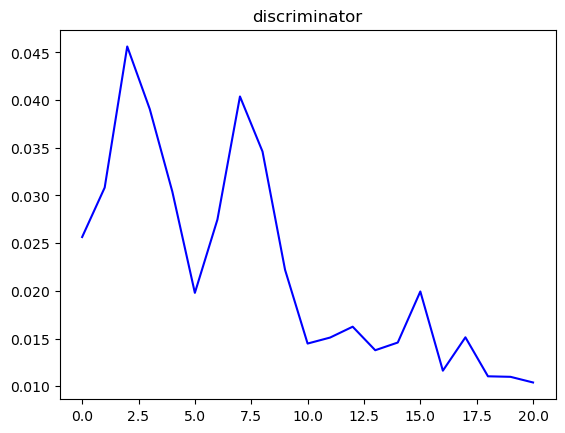

epoch= 21    time= 3.0249 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00858    loss_g= -70.176
epoch= 22    time= 3.1644 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01057    loss_g= -73.660
epoch= 23    time= 3.3036 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00974    loss_g= -77.616
epoch= 24    time= 3.4436 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00727    loss_g= -81.682
epoch= 25    time= 3.5824 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0006    loss_g= -84.794
epoch= 26    time= 3.7213 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00765    loss_g= -87.286
epoch= 27    time= 3.8601 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00563    loss_g= -92.250
epoch= 28    time= 4.0004 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00821    loss_g= -98.006
epoch= 29    time= 4.1396 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00485    loss_g= -102.14
epoch= 30    time= 4.2798 min    lr_d= 0.00030

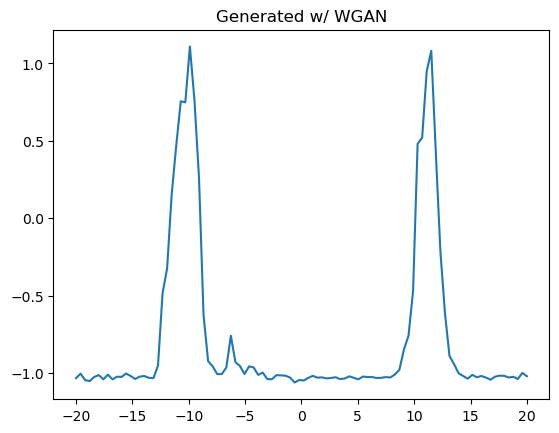

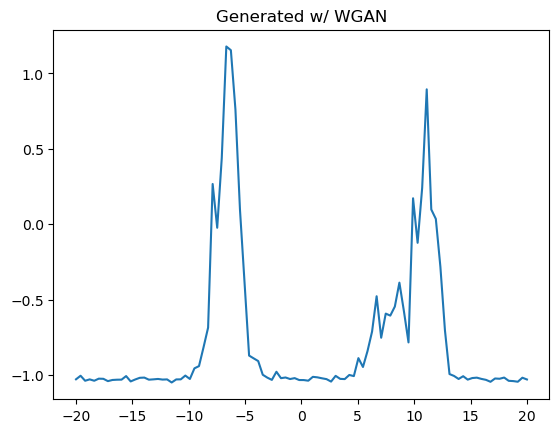

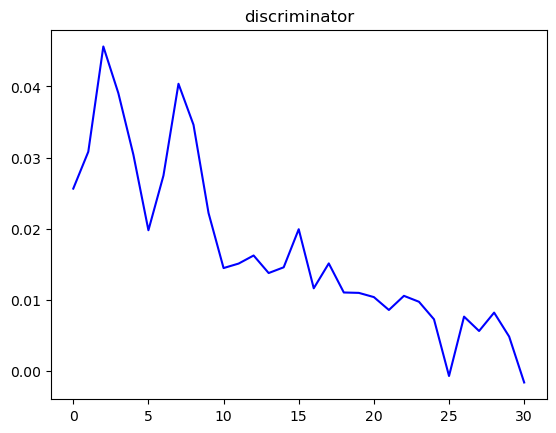

epoch= 31    time= 4.4247 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00572    loss_g= -108.45
epoch= 32    time= 4.5648 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00500    loss_g= -112.75
epoch= 33    time= 4.7016 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00281    loss_g= -117.49
epoch= 34    time= 4.8363 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00826    loss_g= -121.28
epoch= 35    time= 4.9708 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00526    loss_g= -125.94
epoch= 36    time= 5.1055 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00262    loss_g= -131.03
epoch= 37    time= 5.2404 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00726    loss_g= -134.66
epoch= 38    time= 5.3750 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00597    loss_g= -140.96
epoch= 39    time= 5.5097 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00997    loss_g= -146.25
epoch= 40    time= 5.6336 min    lr_d= 0.00030

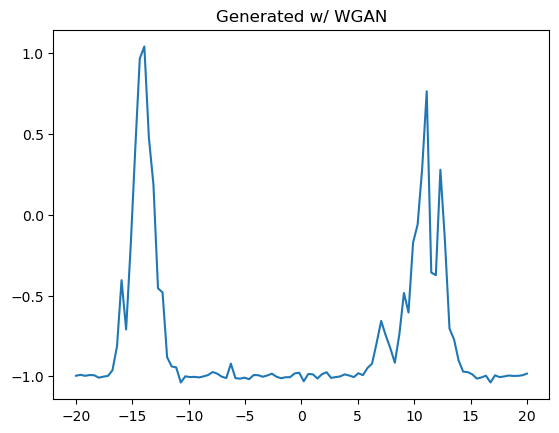

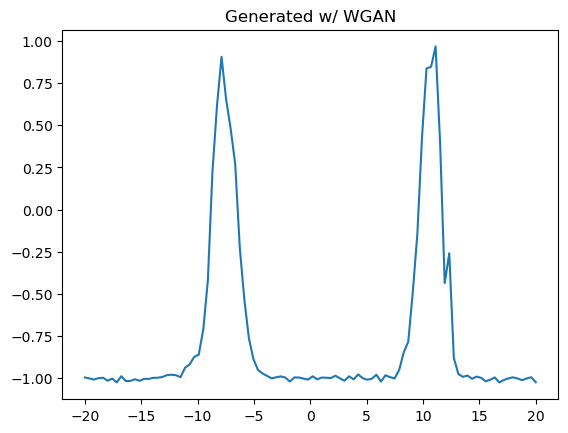

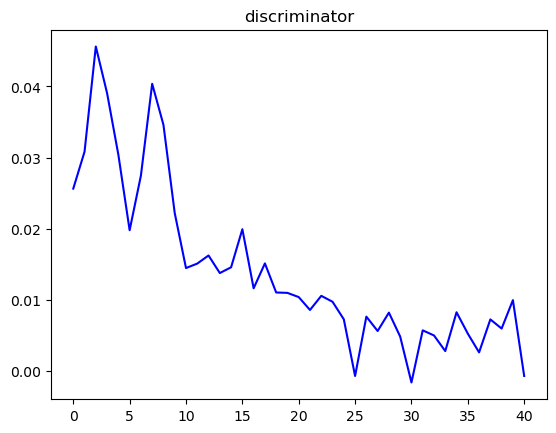

epoch= 41    time= 5.7631 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0013    loss_g= -153.96
epoch= 42    time= 5.8869 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00252    loss_g= -155.68
epoch= 43    time= 6.0106 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01347    loss_g= -160.37
epoch= 44    time= 6.1343 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0015    loss_g= -165.44
epoch= 45    time= 6.2580 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00165    loss_g= -171.12
epoch= 46    time= 6.3818 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00400    loss_g= -174.43
epoch= 47    time= 6.5055 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00242    loss_g= -179.28
epoch= 48    time= 6.6292 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00652    loss_g= -185.31
epoch= 49    time= 6.7530 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00935    loss_g= -190.78
epoch= 50    time= 6.8767 min    lr_d= 0.00030

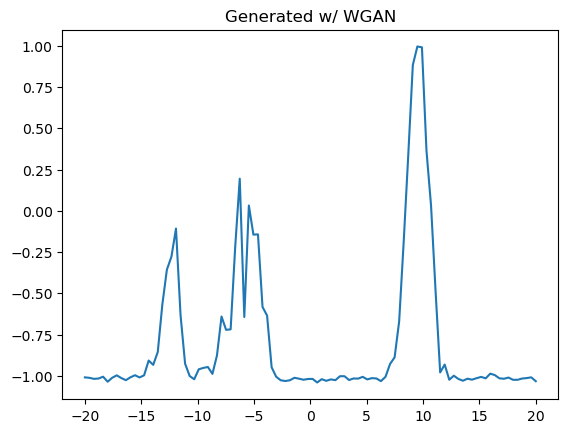

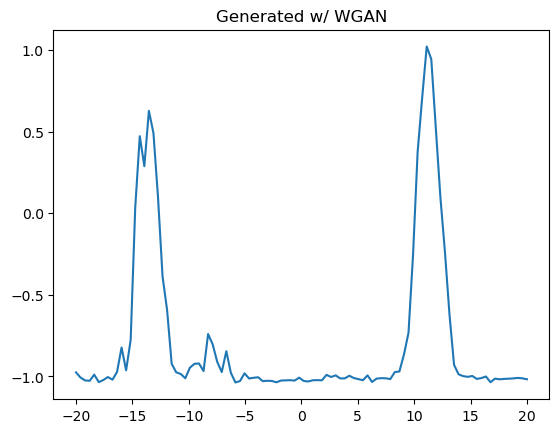

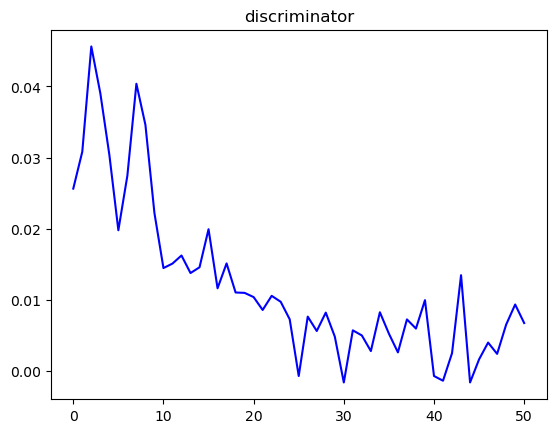

epoch= 51    time= 7.0063 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00755    loss_g= -200.80
epoch= 52    time= 7.1300 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00575    loss_g= -207.33
epoch= 53    time= 7.2538 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00967    loss_g= -214.17
epoch= 54    time= 7.3775 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0058    loss_g= -219.30
epoch= 55    time= 7.5033 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00133    loss_g= -224.23
epoch= 56    time= 7.6397 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00440    loss_g= -228.73
epoch= 57    time= 7.7637 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00671    loss_g= -232.04
epoch= 58    time= 7.8874 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0005    loss_g= -237.43
epoch= 59    time= 8.0111 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00041    loss_g= -241.85
epoch= 60    time= 8.1348 min    lr_d= 0.00030

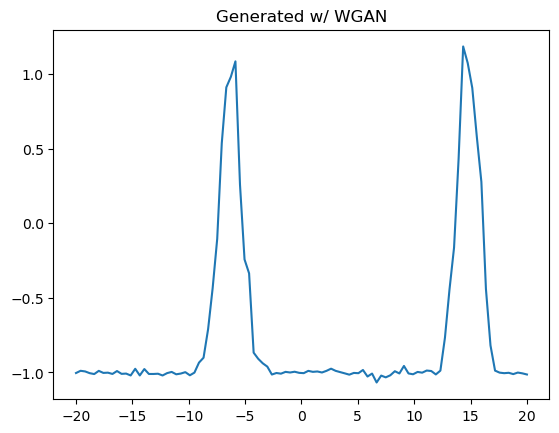

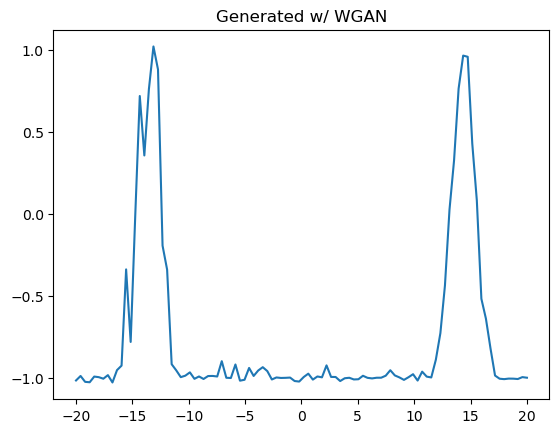

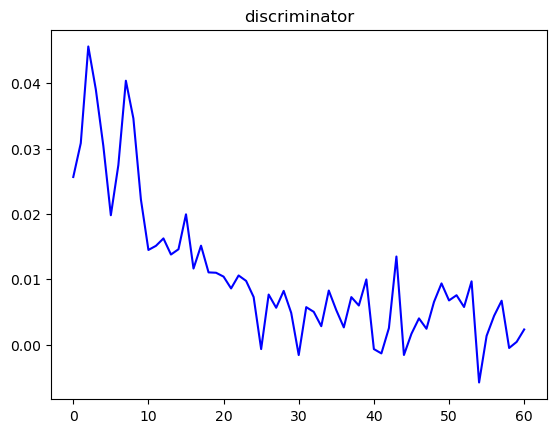

epoch= 61    time= 8.2641 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00466    loss_g= -254.84
epoch= 62    time= 8.3908 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00647    loss_g= -259.36
epoch= 63    time= 8.5267 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00510    loss_g= -263.03
epoch= 64    time= 8.6618 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00452    loss_g= -269.30
epoch= 65    time= 8.7976 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0040    loss_g= -277.30
epoch= 66    time= 8.9332 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0008    loss_g= -282.63
epoch= 67    time= 9.0692 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0034    loss_g= -288.98
epoch= 68    time= 9.2057 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0013    loss_g= -297.62
epoch= 69    time= 9.3422 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0113    loss_g= -304.88
epoch= 70    time= 9.4788 min    lr_d= 0.00030

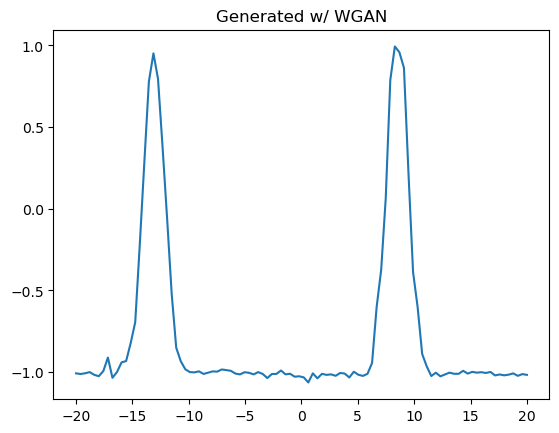

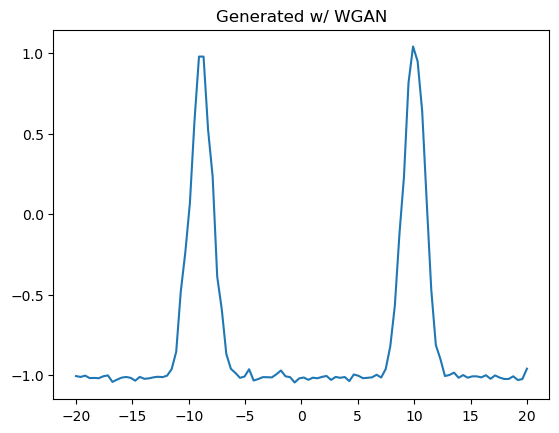

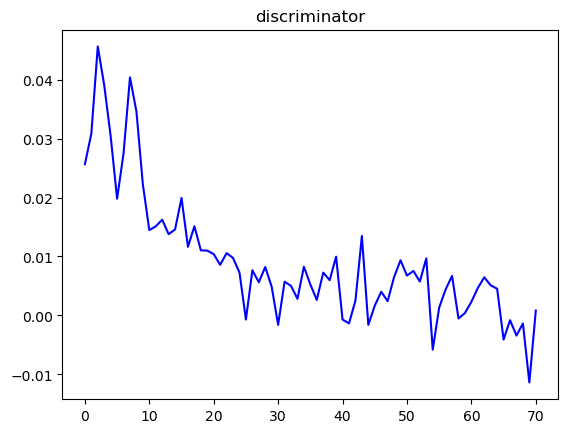

epoch= 71    time= 9.6236 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0059    loss_g= -312.58
epoch= 72    time= 9.7601 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00661    loss_g= -318.31
epoch= 73    time= 9.8968 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0099    loss_g= -327.85
epoch= 74    time= 10.033 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0065    loss_g= -334.46
epoch= 75    time= 10.168 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0007    loss_g= -339.97
epoch= 76    time= 10.305 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00718    loss_g= -344.57
epoch= 77    time= 10.441 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0039    loss_g= -351.69
epoch= 78    time= 10.578 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00210    loss_g= -355.10
epoch= 79    time= 10.714 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00034    loss_g= -361.00
epoch= 80    time= 10.849 min    lr_d= 0.00030

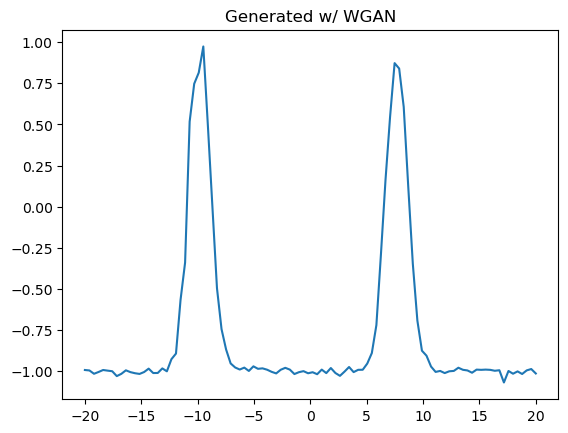

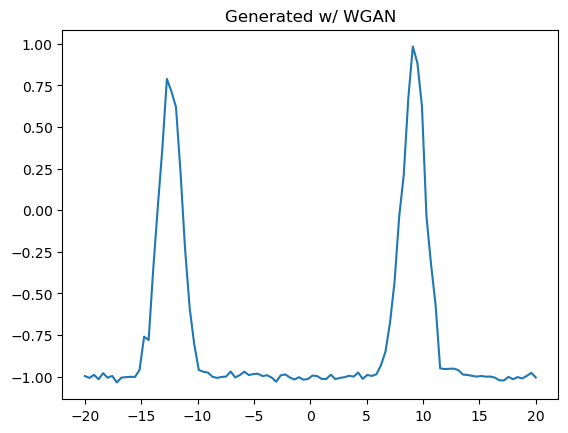

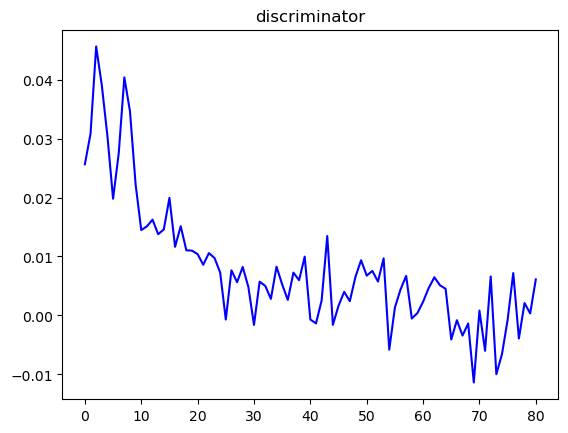

epoch= 81    time= 10.991 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0040    loss_g= -373.06
epoch= 82    time= 11.127 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01365    loss_g= -378.37
epoch= 83    time= 11.262 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0085    loss_g= -386.25
epoch= 84    time= 11.398 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0051    loss_g= -392.42
epoch= 85    time= 11.533 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0170    loss_g= -396.01
epoch= 86    time= 11.668 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00708    loss_g= -403.84
epoch= 87    time= 11.804 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0034    loss_g= -408.91
epoch= 88    time= 11.941 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00239    loss_g= -416.05
epoch= 89    time= 12.076 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00324    loss_g= -424.92
epoch= 90    time= 12.212 min    lr_d= 0.00030

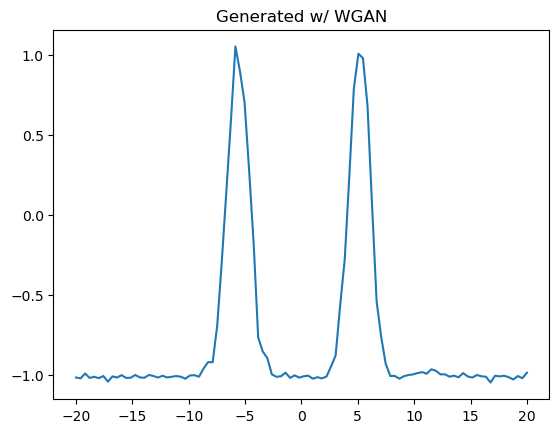

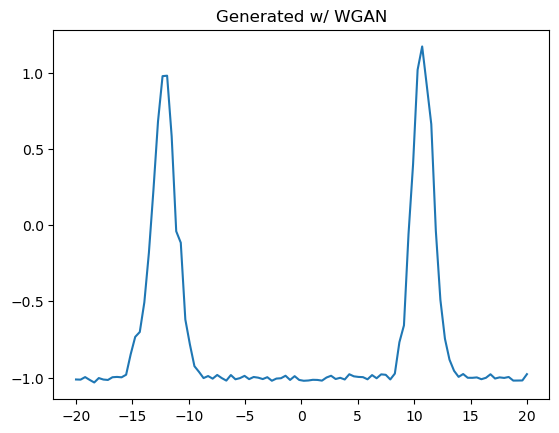

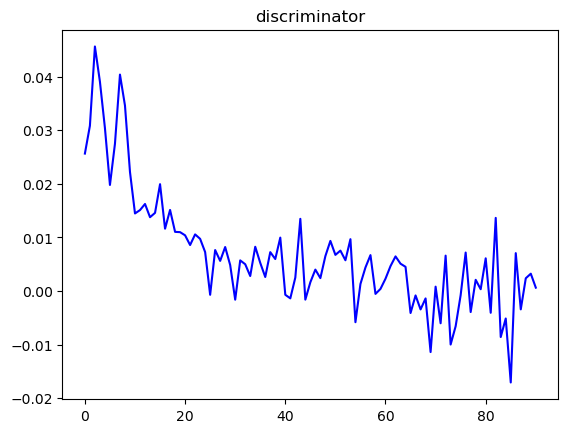

epoch= 91    time= 12.354 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00643    loss_g= -447.90
epoch= 92    time= 12.491 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00340    loss_g= -454.59
epoch= 93    time= 12.627 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0043    loss_g= -462.37
epoch= 94    time= 12.763 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0051    loss_g= -469.52
epoch= 95    time= 12.898 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0091    loss_g= -478.65
epoch= 96    time= 13.034 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00828    loss_g= -487.02
epoch= 97    time= 13.170 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0035    loss_g= -492.43
epoch= 98    time= 13.306 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00304    loss_g= -493.69
epoch= 99    time= 13.441 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0086    loss_g= -501.09


In [7]:
# Training loop
del net
net = WGAN()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.0003
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr, betas=(0.0, 0.9))
scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(optimizer_g, mode='min', factor=0.95, patience=1, verbose=True)

print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)

# Number of mini-batches per epoch
nb_epochs = 100
run_every_k_steps = 5

list_loss_dis = []
list_loss_gen = []

start = time.time()
for epoch in range(nb_epochs):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0

    net.train()
    
    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        # discriminator update
        idx_real = shuffled_indices[count : count+bs]
        x_real = train_data[idx_real,:].to(device) # [bs, n]
        z = torch.rand(bs, dz).to(device) # [bs, dz]    
        x_fake = net.forward_gen(z) # [bs, n]
        fake_discr = net.forward_dis(x_fake) # [bs, 1]    
        real_discr = net.forward_dis(x_real) # [bs, 1]
        loss = fake_discr.mean() - real_discr.mean()
        epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
        x_hat = epsilon * x_fake + (1 - epsilon) * x_real
        xhat_discr = net.forward_dis(x_hat)
        grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
        penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
        loss = loss + 10 * penalty
        running_loss_d = -loss.detach().cpu().item() 
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # generator update
        if count % run_every_k_steps == 0:
            z = torch.rand(bs, dz).to(device) # [bs, dz]
            loss = - net.forward_dis(net.forward_gen(z)).mean()
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()
        running_loss_g += loss.detach().cpu().item() 

        # Compute stats
        num_batches += 1


    # Average stats
    mean_loss_d = running_loss_d/ num_batches
    mean_loss_g = running_loss_g/ num_batches
    if epoch>25:
        scheduler_g.step(mean_loss_g)
        optimizer_d.param_groups[0]['lr'] = optimizer_g.param_groups[0]['lr']
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '   time=', str(elapsed)[:6],'min', '   lr_d=', '{:.7f}'.format(optimizer_d.param_groups[0]['lr']) , \
          '   lr_g=', '{:.7f}'.format(optimizer_g.param_groups[0]['lr']) , \
          '   loss_d=', str(mean_loss_d)[:7] ,'   loss_g=', str(mean_loss_g)[:7] )
    list_loss_dis.append(mean_loss_d)
    list_loss_gen.append(mean_loss_g)

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        # plt.plot(torch.tensor(list_loss_dis),'b-'); plt.title('discriminator'); plt.show() 
        plt.plot(torch.tensor(list_loss_gen),'b-'); plt.title('generator'); plt.show() 

    # Check lr value
    if optimizer_d.param_groups[0]['lr'] < 10**-5: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Q3: Generate new data

Hints: 
- Sample noise `z` from uniform distribution. Use [torch.rand()](https://pytorch.org/docs/stable/generated/torch.rand.html#torch.rand).
- Pass through generator.

batch_x_0 torch.Size([16, 100])


<Figure size 1280x960 with 0 Axes>

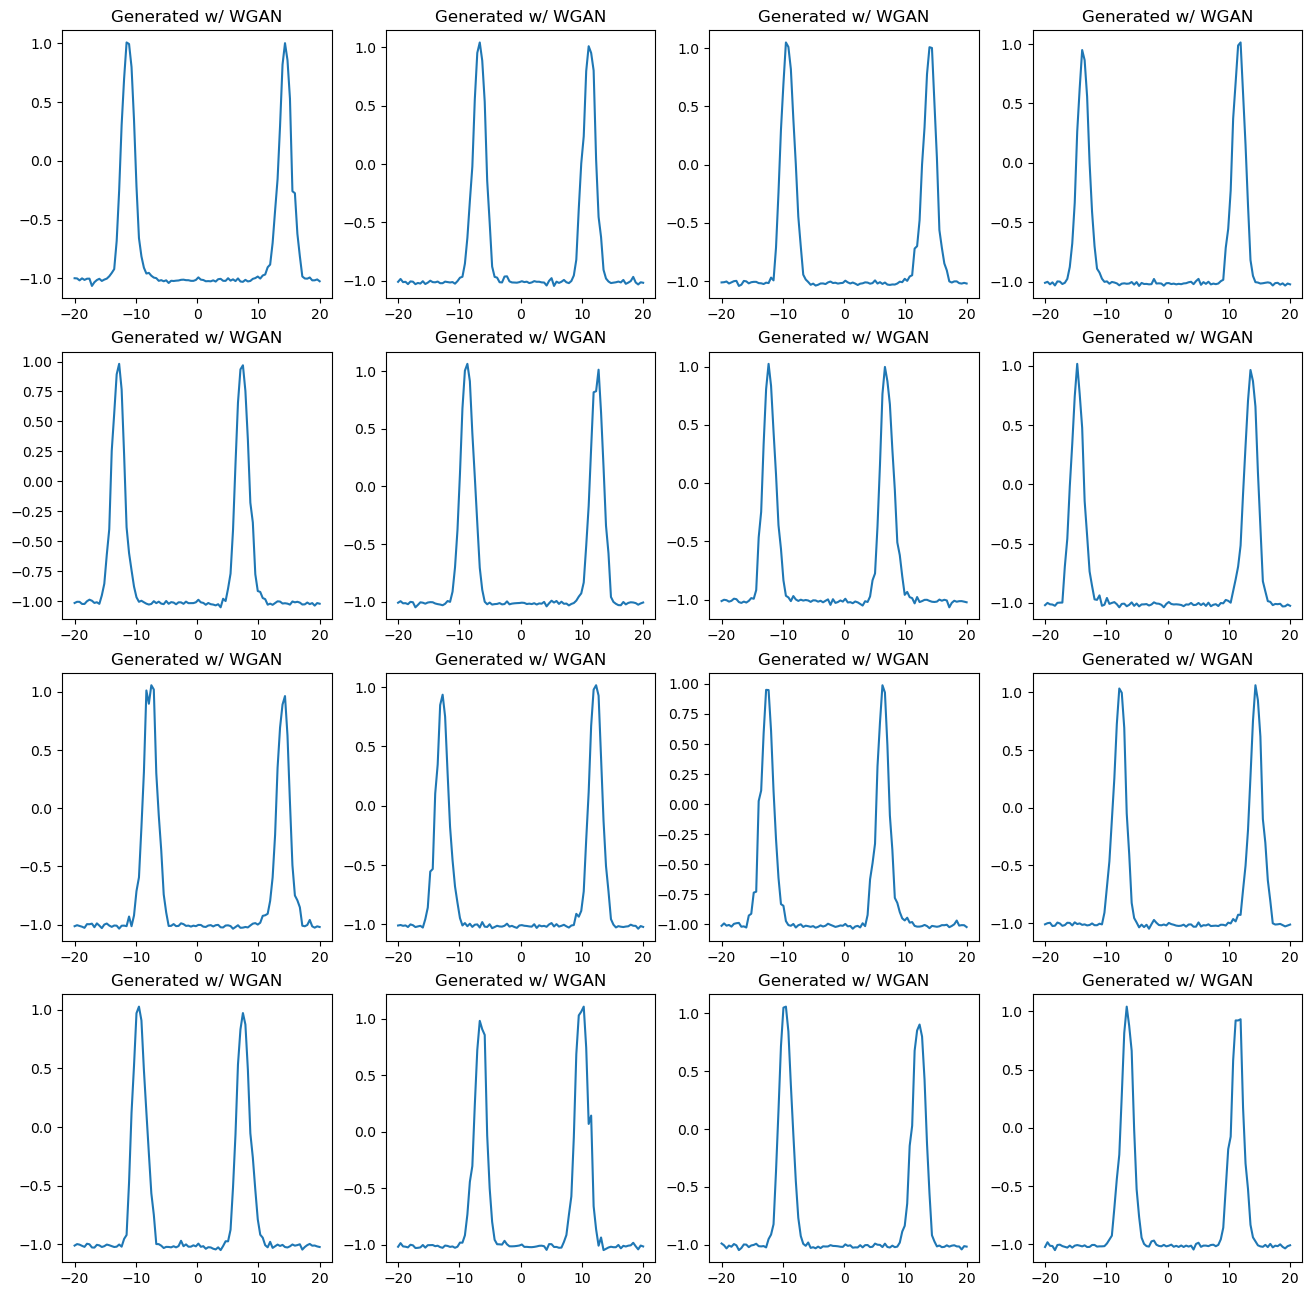

In [8]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    batch_x_0 = # [bs, n]
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
plt.show()
